In [1]:
!pip install torchsummary

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torchvision.models as model
from torchsummary import summary
from sklearn.metrics import precision_score, f1_score,recall_score,accuracy_score
from torch.optim.lr_scheduler import StepLR

!pip install torchview
import torchvision
from torchview import draw_graph

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
!mkdir output

In [4]:

__all__ = ['UNet', 'NestedUNet']


class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out


class UNet(nn.Module):
    def __init__(self, num_classes, input_channels=3, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])
        self.conv2_2 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv1_3 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv0_4 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])

        self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x4_0 = self.conv4_0(self.pool(x3_0))

        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, self.up(x1_3)], 1))

        output = self.final(x0_4)
        return output


class NestedUNet(nn.Module):
    def __init__(self, num_classes, input_channels=3, deep_supervision=False, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = self.final(x0_4)
            return output

In [5]:
model = NestedUNet(1)

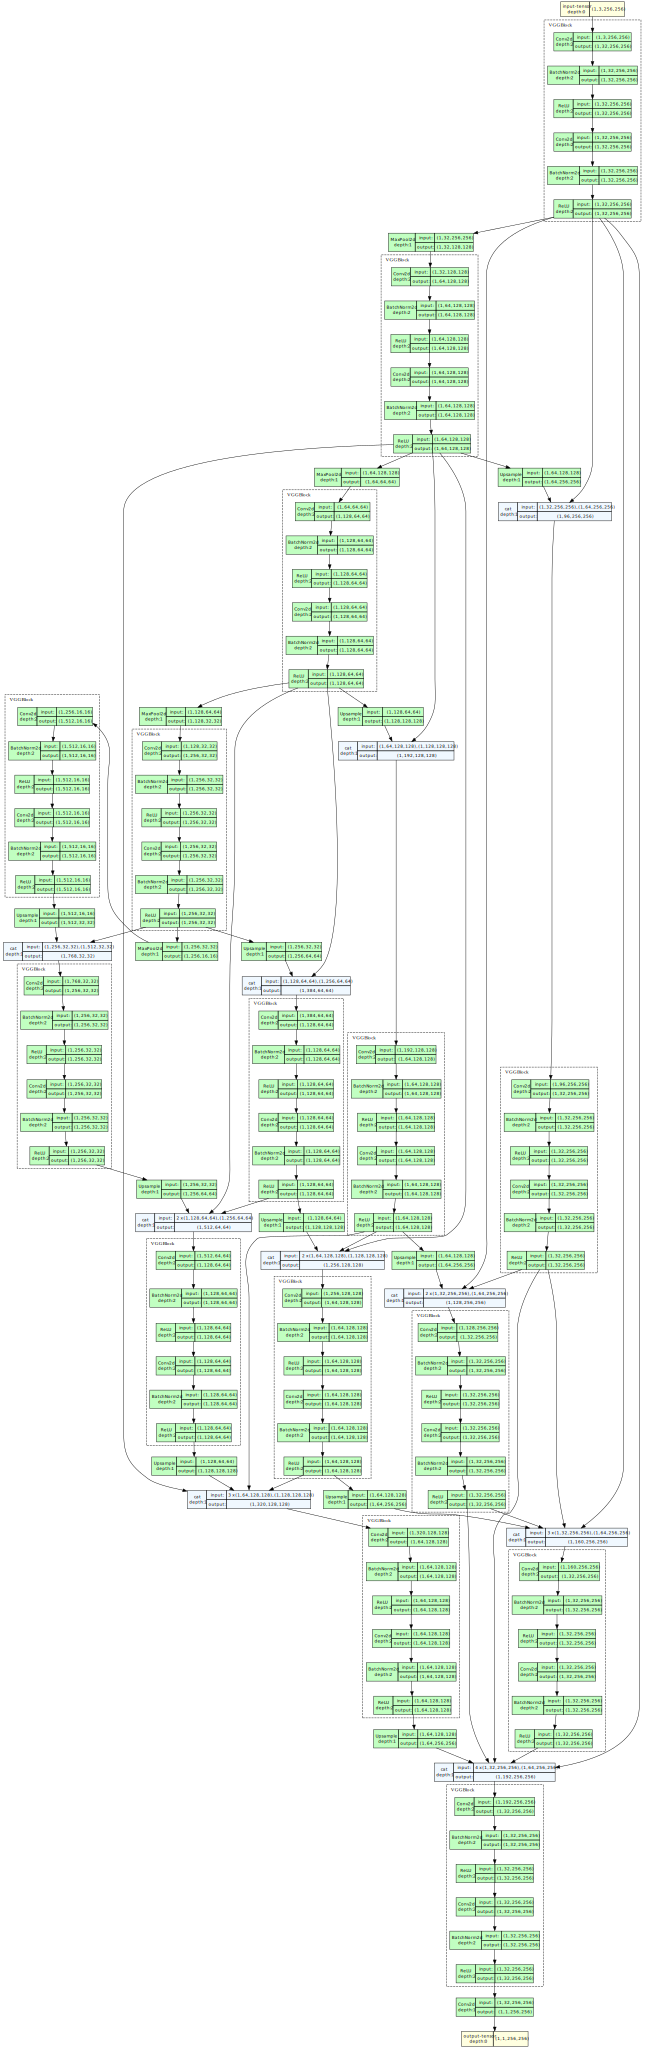

In [6]:
model_graph = draw_graph(model, input_size=(1,3,256,256), expand_nested=True)
model_graph.visual_graph

In [7]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import random

In [8]:
class SlumDataset(Dataset):
  def __init__(self,image_dir,mask_dir,transform = None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)
    self.masks = os.listdir(mask_dir)

  def __len__(self):
    return len(self.masks)

  def __getitem__(self,index):
    img_path = os.path.join(self.image_dir,self.images[index])
    mask_path = os.path.join(self.mask_dir,self.masks[index])

    image = np.array(Image.open(img_path))
    mask = np.array(Image.open(mask_path), dtype = np.float32)
    mask = (mask//246.0)
    image = (image/255.0)


    if self.transform != None:
      augment = self.transform(image = image,mask = mask)
      image = augment['image']
      mask = augment['mask']

      if(image.shape[1:] != mask.shape):
        print("-------------- ---------------------------")
        print("!!!Warning!!!")
        print(image.shape[1:])
        print(mask.shape)

    return image,mask

Just for checking the above code

In [9]:
import torch
import torchvision
from torch.utils.data import DataLoader

In [10]:
def save_checkpoint(state,filename = "my_checkpoint.pth.tar"):
  print("=> Saving checkpoint")
  torch.save(state,filename)

In [11]:
def load_checkpoint(checkpoint,model,optimizer):
  print("=> Loading checkpoint")
  model.load_state_dict(checkpoint["state_dict"])
  optimizer.load_state_dict(checkpoint["optimizer"])

In [12]:
def get_loaders(
    train_dir,
    train_mask_dir,
    val_dir,
    val_mask_dir,
    batch_size,
    train_transform,
    val_transform,
    train_val,
    num_workers = 2,
    pin_memory = True,
):

  train_ds = SlumDataset(
      image_dir = train_dir,
      mask_dir = train_mask_dir,
      transform = train_transform
  )

  train_loader = DataLoader(
      train_ds,
      batch_size = batch_size,
      num_workers = num_workers,
      pin_memory = pin_memory,
      shuffle = True,
  )

  val_ds = SlumDataset(
      image_dir = val_dir,
      mask_dir = val_mask_dir,
      transform = val_transform
  )

  val_loader = DataLoader(
      val_ds,
      batch_size = batch_size,
      num_workers = num_workers,
      pin_memory = pin_memory,
      shuffle = False,
  )

  return train_loader, val_loader

In [13]:
def dice_coefficient(predicted_mask, ground_truth_mask):
  intersection = np.sum(predicted_mask * ground_truth_mask)
  predicted_area = np.sum(predicted_mask)
  ground_truth_area = np.sum(ground_truth_mask)

  dice = (2.0 * intersection) / (predicted_area + ground_truth_area)
  return dice

def check_accuracy(loss_fn,loader,model,accuracy_vals,dice_scores,iou_scores,precision_scores,recall_scores,f1_val,val_loss,device = "cuda"):
  num_correct = 0
  num_pixels = 0
  dice_s = []
  precision_s = []
  f1_s = []
  iou_s = []
  recall_s = []
  accuracy_s = []
  model.eval()

  with torch.no_grad():
    for x,y in loader:
      x = x.to(device)
      y = y.to(device).unsqueeze(1)
      pred = torch.sigmoid(model(x))

      val_loss += loss_fn(y,pred).item()

      pred = (pred > 0.5).float()
      num_correct += (pred == y).sum()
      num_pixels += torch.numel(pred)
      preds = pred.cpu().numpy()
      yy = y.cpu().numpy()


      for pred_mask, gt_mask in zip(preds, yy):
        # Flatten the binary masks for precision calculation
        pred_mask_flat = pred_mask.flatten()
        gt_mask_flat = gt_mask.flatten()

        # Calculate recall score for the current mask
        recall = recall_score(gt_mask_flat, pred_mask_flat)
        recall_s.append(recall)

        # Calculate precision for the current mask
        precision = precision_score(gt_mask_flat, pred_mask_flat)
        precision_s.append(precision)

        # Calculate F1 score for the current mask
        # F1-score is the harmonic mean of Precision and Recall,
        # F1-score = 2 * (Precision * Recall) / (Precision + Recall)

        f1 = f1_score(gt_mask_flat, pred_mask_flat)
        f1_s.append(f1)

        # Calculate the intersection and union of the binary masks
        intersection = np.sum(pred_mask * gt_mask)
        union = np.sum(np.logical_or(pred_mask, gt_mask))

        # Calculate IoU for the current mask
        iou = intersection / union
        iou_s.append(iou)

        # Calculate Accuarcy for the current mask
        accuracy = np.mean(gt_mask_flat == pred_mask_flat)
        accuracy_s.append(accuracy)

        dice_score = dice_coefficient(pred_mask, gt_mask)
        dice_s.append(dice_score)

  val_loss /= len(loader)
  accu = (num_correct/num_pixels)*100
  print(f"Got {num_correct}/{num_pixels} with accuracy {accu}")

  # Calculate the average precision over the validation dataset
  average_precision = np.mean(precision_s)
  print(f"Average Precision: {average_precision:.4f}")

  #Calculate the average accuracy over the validation dataset
  accuracy_vals.append(np.mean(accuracy_s))
  print(f'Accuracy: {np.mean(accuracy_s)}')

  # Calculate the average Dice score over the validation dataset
  average_dice = np.mean(dice_s)
  print(f"Average Dice Score: {average_dice:.4f}")

  # Calculate the average F1 score over the validation dataset
  average_f1 = np.mean(f1_s)
  print(f"Average F1 Score: {average_f1:.4f}")

  # Calculate the average IoU score over the validation dataset
  average_iou = np.mean(iou_s)
  print(f"Average IoU Score: {average_iou:.4f}")

  # Calculate average metrics for the epoch
  iou_scores.append(average_iou)
  precision_scores.append(average_precision)
  recall_scores.append(np.mean(recall_s))
  f1_val.append(average_f1)
  dice_scores.append(average_dice)

  model.train()

In [14]:
def save_predictions_as_imgs(loader,model,folder="saved_images/",device = "cuda"):
  model.eval()
  for idx, (x,y) in enumerate(loader):
    x = x.to(device = device)

    with torch.no_grad():
      preds = torch.sigmoid(model(x))
      preds = (preds > 0.5).float()
      # preds = (preds > 0.5).astype(torch.int)

    torchvision.utils.save_image(preds,f"{folder}/pred_{idx}.jpg")
    torchvision.utils.save_image(y.unsqueeze(1),f"{folder}/{idx}.jpg")

  model.train()


def my_plot(epochs, loss):
  plt.xlabel("losses")
  plt.ylabel("Num of epochs")
  plt.plot(epochs, loss)

In [15]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from numpy import random

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

# Hyperparameters
LEARNING_RATE = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 15
NUM_WORKERS = 2
train_val = 0.8
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
train_valid = 0.8

PIN_MEMORY = True
LOAD_MODEL = True

TRAIN_IMG_DIR = '/kaggle/input/slum-dataset/train_img/train_img'
TRAIN_MASK_DIR = '/kaggle/input/slum-dataset/train_mask-20230822T130205Z-001/train_mask'
val_dir = '/kaggle/input/slum-dataset/val_img-20230822T130211Z-001/val_img'
val_mask_dir = '/kaggle/input/slum-dataset/val_mask-20230822T130216Z-001/val_mask'
saved_folder = '/kaggle/working/'

/tmp/ipykernel_26/1993719355.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


In [16]:
# Custom Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss()(inputs, targets)
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss

In [17]:
def train_fn(epoch,num_epochs,loader,model,optimizer,loss_fn,scaler,iou_train,precision_train,recall_train,f1_train,loss_train,accuracy_train):
  total_loss = 0.0
  total_iou = 0.0
  total_precision = 0.0
  total_recall = 0.0
  total_f1 = 0.0
  total_accuracy = 0.0
  accuracy_s = []

  length = len(loader);
  loop = tqdm(loader)

  for batch_idx, (data,targets) in enumerate(loop):
    data = data.to(device = device)
    targets = targets.float().unsqueeze(1).to(device = device)
    targ = targets

    # forward
    with torch.cuda.amp.autocast():
      predictions = torch.sigmoid(model(data))

      loss = loss_fn(predictions,targets)
      total_loss += loss.item()

      # convert model outputs to binary mask using sigmoid and threshold
      predicted_masks = predictions
      predicted_masks = (predicted_masks > 0.5).float()

      preds = predicted_masks.cpu().numpy()
      yy = targ.cpu().numpy()

      # Calculate the intersection and union of the binary masks
      intersection = np.sum(preds * yy)
      union = np.sum(np.logical_or(preds, yy))
      iou = intersection / union

      precision = precision_score(yy.flatten(), preds.flatten())
      recall = recall_score(yy.flatten(), preds.flatten())
      f1 = f1_score(yy.flatten(), preds.flatten())
    
      for pred_mask,gt_mask in zip(preds,yy):
        x = np.mean(gt_mask.flatten() == pred_mask.flatten())
        accuracy_s.append(x)

      total_iou += iou
      total_precision += precision
      total_recall += recall
      total_f1 += f1
      # total_accuracy += accuracy

    # backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # update tqdm loop
    loop.set_postfix(loss = loss.item())

  average_loss = total_loss / length
  average_iou = total_iou / length
  average_precision = total_precision / length
  average_recall = total_recall / length
  average_f1 = total_f1 / length
  # average_accuracy = accuracy /length

  # Append metrics and losses to lists for plotting
  loss_train.append(average_loss)
  iou_train.append(average_iou)
  precision_train.append(average_precision)
  recall_train.append(average_recall)
  f1_train.append(average_f1)
  accuracy_train.append(np.mean(accuracy_s))

  print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Loss: {average_loss:.4f}, "
          f"IoU: {average_iou:.4f}, "
          f"Precision: {average_precision:.4f}, "
          f"Recall: {average_recall:.4f}, "
          f"F1: {average_f1:.4f},"
          f"Accuracy: {np.mean(accuracy_s):4f}"
  )


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 178/178 [09:36<00:00,  3.24s/it, loss=0.204]


Epoch [1/15], Loss: 0.1926, IoU: 0.5296, Precision: 0.7323, Recall: 0.6675, F1: 0.6887,Accuracy: 0.833314
=> Saving checkpoint
Got 38273645/46530560 with accuracy 82.25485229492188
Average Precision: 0.5066
Accuracy: 0.8225485573352223
Average Dice Score: 0.6306
Average F1 Score: 0.6306
Average IoU Score: 0.4843


100%|██████████| 178/178 [09:21<00:00,  3.15s/it, loss=0.16]


Epoch [2/15], Loss: 0.1783, IoU: 0.5499, Precision: 0.7869, Recall: 0.6534, F1: 0.7076,Accuracy: 0.848697
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Got 42465785/46530560 with accuracy 91.2642822265625
Average Precision: 0.7819
Accuracy: 0.9126428953358825
Average Dice Score: 0.6668
Average F1 Score: 0.6668
Average IoU Score: 0.5399


100%|██████████| 178/178 [09:17<00:00,  3.13s/it, loss=0.166]


Epoch [3/15], Loss: 0.1707, IoU: 0.5567, Precision: 0.7949, Recall: 0.6547, F1: 0.7132,Accuracy: 0.851593
=> Saving checkpoint
Got 39583442/46530560 with accuracy 85.06976318359375
Average Precision: 0.5424
Accuracy: 0.8506977349939481
Average Dice Score: 0.6610
Average F1 Score: 0.6610
Average IoU Score: 0.5181


100%|██████████| 178/178 [09:20<00:00,  3.15s/it, loss=0.152]


Epoch [4/15], Loss: 0.1665, IoU: 0.5688, Precision: 0.8050, Recall: 0.6664, F1: 0.7233,Accuracy: 0.856606
=> Saving checkpoint
Got 42032461/46530560 with accuracy 90.33301544189453
Average Precision: 0.6589
Accuracy: 0.9033302199672645
Average Dice Score: 0.7346
Average F1 Score: 0.7346
Average IoU Score: 0.6006


100%|██████████| 178/178 [09:22<00:00,  3.16s/it, loss=0.198]


Epoch [5/15], Loss: 0.1655, IoU: 0.5730, Precision: 0.8119, Recall: 0.6676, F1: 0.7268,Accuracy: 0.859607
=> Saving checkpoint
Got 42181657/46530560 with accuracy 90.65365600585938
Average Precision: 0.6775
Accuracy: 0.9065366288306008
Average Dice Score: 0.7386
Average F1 Score: 0.7386
Average IoU Score: 0.6064


100%|██████████| 178/178 [09:17<00:00,  3.13s/it, loss=0.164]


Epoch [6/15], Loss: 0.1646, IoU: 0.5783, Precision: 0.8110, Recall: 0.6738, F1: 0.7313,Accuracy: 0.861026
=> Saving checkpoint
Got 42124867/46530560 with accuracy 90.53160858154297
Average Precision: 0.6645
Accuracy: 0.9053161406181228
Average Dice Score: 0.7400
Average F1 Score: 0.7400
Average IoU Score: 0.6074


100%|██████████| 178/178 [09:23<00:00,  3.16s/it, loss=0.197]


Epoch [7/15], Loss: 0.1642, IoU: 0.5777, Precision: 0.8142, Recall: 0.6715, F1: 0.7305,Accuracy: 0.860670
=> Saving checkpoint
Got 42256513/46530560 with accuracy 90.81452941894531
Average Precision: 0.6715
Accuracy: 0.9081453780053367
Average Dice Score: 0.7474
Average F1 Score: 0.7474
Average IoU Score: 0.6166


100%|██████████| 178/178 [09:17<00:00,  3.13s/it, loss=0.135]


Epoch [8/15], Loss: 0.1631, IoU: 0.5890, Precision: 0.8142, Recall: 0.6862, F1: 0.7397,Accuracy: 0.863975
=> Saving checkpoint
Got 42282739/46530560 with accuracy 90.87089538574219
Average Precision: 0.6720
Accuracy: 0.9087090075855524
Average Dice Score: 0.7468
Average F1 Score: 0.7468
Average IoU Score: 0.6157


100%|██████████| 178/178 [09:11<00:00,  3.10s/it, loss=0.156]


Epoch [9/15], Loss: 0.1629, IoU: 0.5880, Precision: 0.8208, Recall: 0.6795, F1: 0.7388,Accuracy: 0.864648
=> Saving checkpoint
Got 42461106/46530560 with accuracy 91.25422668457031
Average Precision: 0.6851
Accuracy: 0.9125423377668354
Average Dice Score: 0.7511
Average F1 Score: 0.7511
Average IoU Score: 0.6212


100%|██████████| 178/178 [09:19<00:00,  3.14s/it, loss=0.158]


Epoch [10/15], Loss: 0.1634, IoU: 0.5804, Precision: 0.8160, Recall: 0.6744, F1: 0.7329,Accuracy: 0.861976
=> Saving checkpoint
Got 41992784/46530560 with accuracy 90.24774932861328
Average Precision: 0.6527
Accuracy: 0.9024775115536972
Average Dice Score: 0.7378
Average F1 Score: 0.7378
Average IoU Score: 0.6048


100%|██████████| 178/178 [09:12<00:00,  3.10s/it, loss=0.182]


Epoch [11/15], Loss: 0.1633, IoU: 0.5853, Precision: 0.8194, Recall: 0.6786, F1: 0.7367,Accuracy: 0.863412
=> Saving checkpoint
Got 41880156/46530560 with accuracy 90.00569915771484
Average Precision: 0.6457
Accuracy: 0.9000569948008362
Average Dice Score: 0.7337
Average F1 Score: 0.7337
Average IoU Score: 0.6004


100%|██████████| 178/178 [09:17<00:00,  3.13s/it, loss=0.151]


Epoch [12/15], Loss: 0.1630, IoU: 0.5840, Precision: 0.8218, Recall: 0.6755, F1: 0.7358,Accuracy: 0.863570
=> Saving checkpoint
Got 42851848/46530560 with accuracy 92.09398651123047
Average Precision: 0.7144
Accuracy: 0.9209398726342429
Average Dice Score: 0.7631
Average F1 Score: 0.7631
Average IoU Score: 0.6358


100%|██████████| 178/178 [09:21<00:00,  3.15s/it, loss=0.147]


Epoch [13/15], Loss: 0.1628, IoU: 0.5879, Precision: 0.8236, Recall: 0.6780, F1: 0.7388,Accuracy: 0.864791
=> Saving checkpoint
Got 42609695/46530560 with accuracy 91.57356262207031
Average Precision: 0.6958
Accuracy: 0.9157357014400859
Average Dice Score: 0.7556
Average F1 Score: 0.7556
Average IoU Score: 0.6268


100%|██████████| 178/178 [09:14<00:00,  3.12s/it, loss=0.141]


Epoch [14/15], Loss: 0.1628, IoU: 0.5876, Precision: 0.8235, Recall: 0.6780, F1: 0.7386,Accuracy: 0.864864
=> Saving checkpoint
Got 42434416/46530560 with accuracy 91.19686889648438
Average Precision: 0.6810
Accuracy: 0.9119687362455986
Average Dice Score: 0.7525
Average F1 Score: 0.7525
Average IoU Score: 0.6226


100%|██████████| 178/178 [09:30<00:00,  3.20s/it, loss=0.181]


Epoch [15/15], Loss: 0.1628, IoU: 0.5888, Precision: 0.8238, Recall: 0.6794, F1: 0.7397,Accuracy: 0.864982
=> Saving checkpoint
Got 42247032/46530560 with accuracy 90.79415893554688
Average Precision: 0.6680
Accuracy: 0.9079416194432218
Average Dice Score: 0.7460
Average F1 Score: 0.7460
Average IoU Score: 0.6149
Training finished
loss_train : [0.19261230653926228, 0.17832132445627383, 0.17069002458553637, 0.16651976183893974, 0.16550549621997254, 0.16456625284103865, 0.16415298194362876, 0.16314904827080415, 0.16292189806699753, 0.16335526837056943, 0.16327970366129715, 0.16302499191814593, 0.16279211623615095, 0.16284068883135078, 0.16279190795475176]
iou_train : [0.5295698767226364, 0.5498771912708291, 0.5566895539987976, 0.5688148915777647, 0.5729776525600568, 0.5782611189041396, 0.5777410932078649, 0.5890279634502746, 0.5879736860719817, 0.5803879599696917, 0.5853414630681001, 0.58398564397767, 0.5879403765116245, 0.587632431027479, 0.5887755081831053]
precision_train : [0.7322924

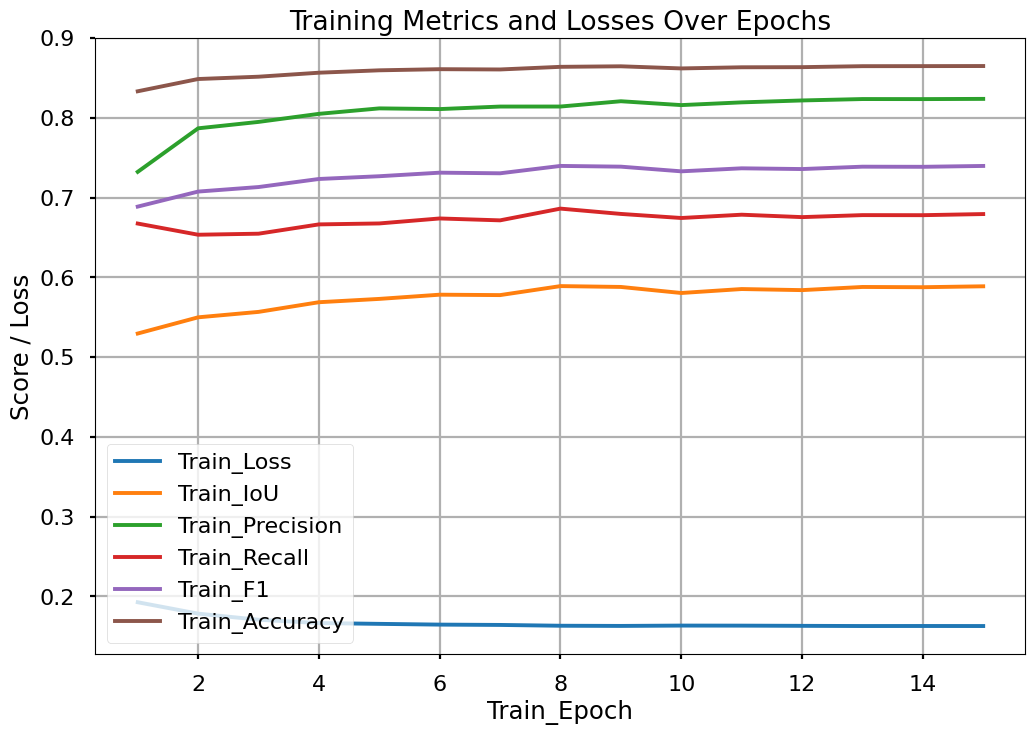

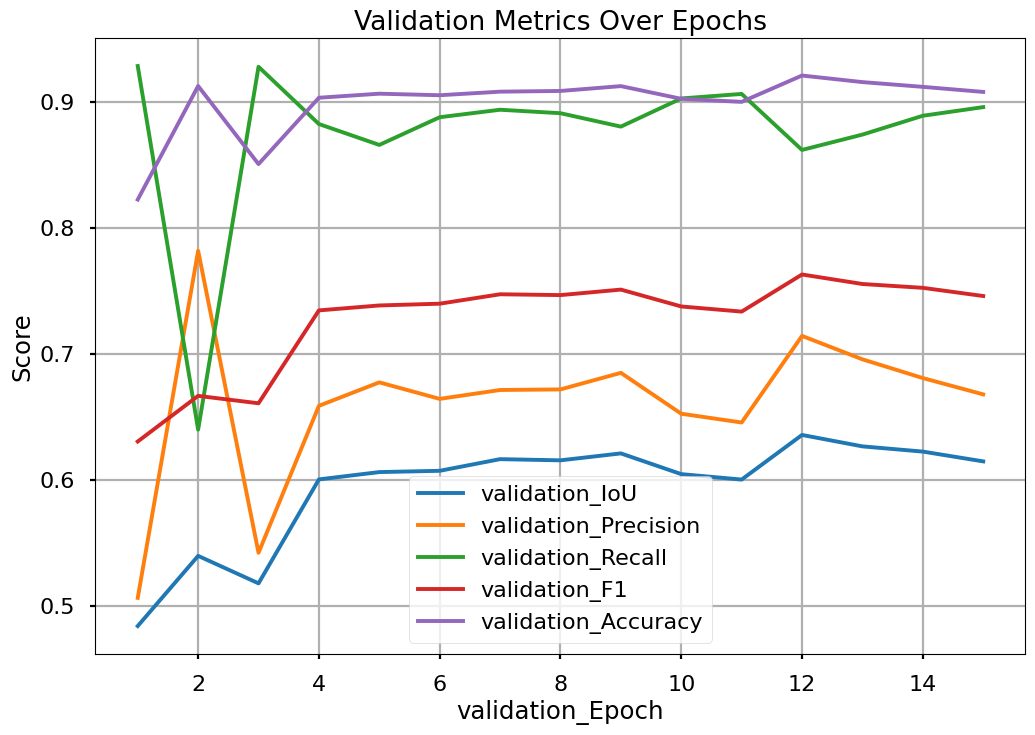

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
          VGGBlock-7         [-1, 32, 256, 256]               0
         MaxPool2d-8         [-1, 32, 128, 128]               0
            Conv2d-9         [-1, 64, 128, 128]          18,496
      BatchNorm2d-10         [-1, 64, 128, 128]             128
             ReLU-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,928
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

In [18]:
def main():
  train_transform = A.Compose(
    [
      A.Resize(height = IMAGE_HEIGHT,width = IMAGE_WIDTH),
      A.RandomCrop(height = IMAGE_HEIGHT,width=IMAGE_WIDTH),
      A.Rotate(limit = 35,p=1.0),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.1),
      A.Normalize(
          mean=[0.0,0.0,0.0],
          std = [1.0,1.0,1.0],
          max_pixel_value = 1.0
      ),
      ToTensorV2(),
    ], is_check_shapes=False
  )

  val_transform = A.Compose(
    [
     A.Resize(height = IMAGE_HEIGHT,width = IMAGE_WIDTH),
     A.RandomCrop(height = IMAGE_HEIGHT,width=IMAGE_WIDTH),
     A.Normalize(
      mean=[0.0,0.0,0.0],
      std = [1.0,1.0,1.0],
      max_pixel_value = 1.0
    ),
    ToTensorV2(),
  ], is_check_shapes=False
  )

  train_loader,val_loader = get_loaders(
      TRAIN_IMG_DIR,
      TRAIN_MASK_DIR,
      val_dir,
      val_mask_dir,
      BATCH_SIZE,
      train_transform,
      val_transform,
      train_val,
      NUM_WORKERS,
      PIN_MEMORY,
  )

  model = NestedUNet(1).to("cuda" if torch.cuda.is_available() else "cpu")
  loss_fn = FocalLoss()

  optimizer = optim.Adam(model.parameters(),lr = LEARNING_RATE)
  scheduler = StepLR(optimizer, step_size=4, gamma=0.1)

  # if LOAD_MODEL:
    # load_checkpoint(torch.load("my_checkpoint.pth.tar"),model)
    # load_checkpoint(torch.load("my_checkpoint.pth.tar"),model,optimizer=optimizer)

  scaler = torch.cuda.amp.GradScaler()

  # Initialize lists to store metric values for each epoch for validation dataset
  iou_scores = []
  precision_scores = []
  recall_scores = []
  f1_val = []
  dice_scores = []
  accuracy_vals = []

  # Initialize lists to store metric values for each epoch for training dataset
  iou_train = []
  precision_train = []
  recall_train = []
  f1_train = []
  loss_train = []
  accuracy_train = []

  # Number of patience for early stopping
  patience = 10
  # best_val_loss = float('inf')
  best_val_loss = torch.tensor(float('inf'))
  counter = 0

  for epoch in range(NUM_EPOCHS):
    scheduler.step()
    train_fn(epoch,NUM_EPOCHS,train_loader,model,optimizer,loss_fn,scaler,iou_train,precision_train,recall_train,f1_train,loss_train,accuracy_train)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)

    # check_accuracy
    val_loss = 0.0
    check_accuracy(loss_fn,val_loader,model,accuracy_vals,dice_scores,iou_scores,precision_scores,recall_scores,f1_val,val_loss,device = DEVICE)

#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         counter = 0
#     else:
#         counter += 1
#         if counter >= patience:
#             print("Early stopping triggered.")
#             break

    # print some examples to the folder
    save_predictions_as_imgs(
        val_loader,model,folder=saved_folder,device = DEVICE
    )
  print("Training finished")
  print(f'loss_train : {loss_train}')
  print(f'iou_train : {iou_train}')
  print(f'precision_train : {precision_train}')
  print(f'recall_train : {recall_train}')
  print(f'f1_train : {f1_train}')
  
  print(f'Validation result')
  print(f'f1_val: {f1_val}')
  print(f'dice_scores : {dice_scores}')
  print(f'iou_scores : {iou_scores}')
  print(f'precision_scores : {precision_scores}')
  print(f'recall_scores : {recall_scores}')
  print(f'Accuracy_scores : {accuracy_vals}')

  # Plot metrics and losses
  # Plot for Training dataset
  epochs = np.arange(1, NUM_EPOCHS + 1)
  plt.figure(figsize=(12, 8))

  plt.plot(epochs, loss_train, label='Train_Loss')
  plt.plot(epochs, iou_train, label='Train_IoU')
  plt.plot(epochs, precision_train, label='Train_Precision')
  plt.plot(epochs, recall_train, label='Train_Recall')
  plt.plot(epochs, f1_train, label='Train_F1')
  plt.plot(epochs, accuracy_train, label='Train_Accuracy')

  plt.xlabel('Train_Epoch')
  plt.ylabel('Score / Loss')
  plt.title('Training Metrics and Losses Over Epochs')
  plt.legend()
  plt.grid()

  plt.show()

  # PLot validation metrics
  plt.figure(figsize=(12, 8))

  plt.plot(epochs, iou_scores, label='validation_IoU')
  plt.plot(epochs, precision_scores, label='validation_Precision')
  plt.plot(epochs, recall_scores, label='validation_Recall')
  plt.plot(epochs, dice_scores, label='validation_F1')
  plt.plot(epochs,accuracy_vals,label = "validation_Accuracy")

  plt.xlabel('validation_Epoch')
  plt.ylabel('Score')
  plt.title('Validation Metrics Over Epochs')
  plt.legend()
  plt.grid()

  plt.show()

  summary(model,input_size = (3,IMAGE_HEIGHT,IMAGE_WIDTH))

if __name__ == "__main__":
  main()